In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from pydicom import dcmread
%matplotlib inline
tf.__version__

import sys
print(sys.version)
print(sys.executable)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
C:\ProgramData\Anaconda3\python.exe


In [2]:
import glob
files = glob.glob("001/*.dcm")
ds = dcmread(files[0])
# print(ds)

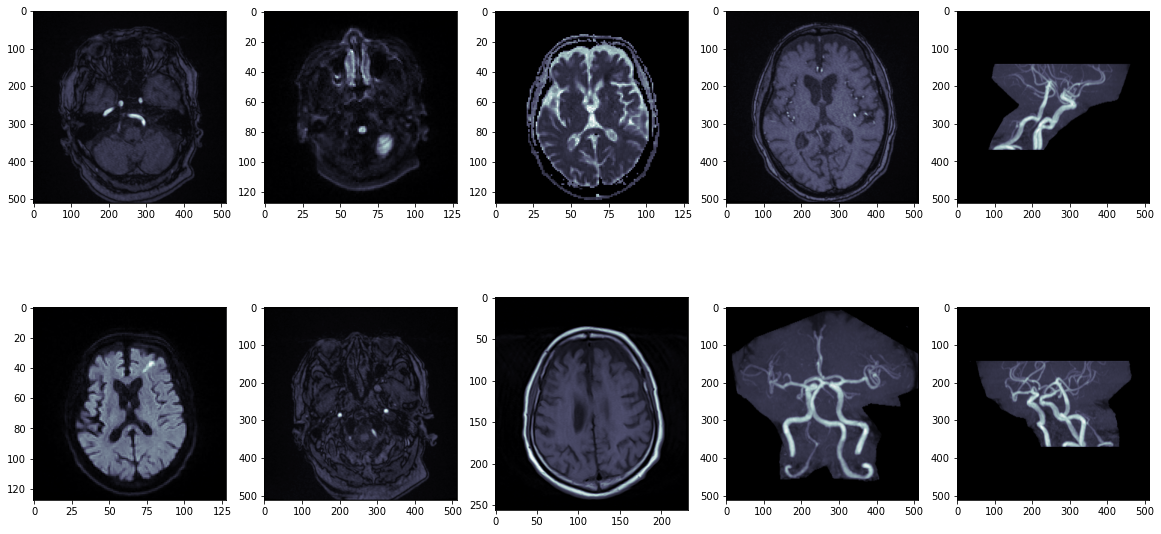

In [3]:
fig,ax = plt.subplots(2,5,figsize=(20,10))
for i in range(10):
    ds = dcmread(files[i])
    ax[i%2][i//2].imshow(ds.pixel_array, cmap=plt.cm.bone)

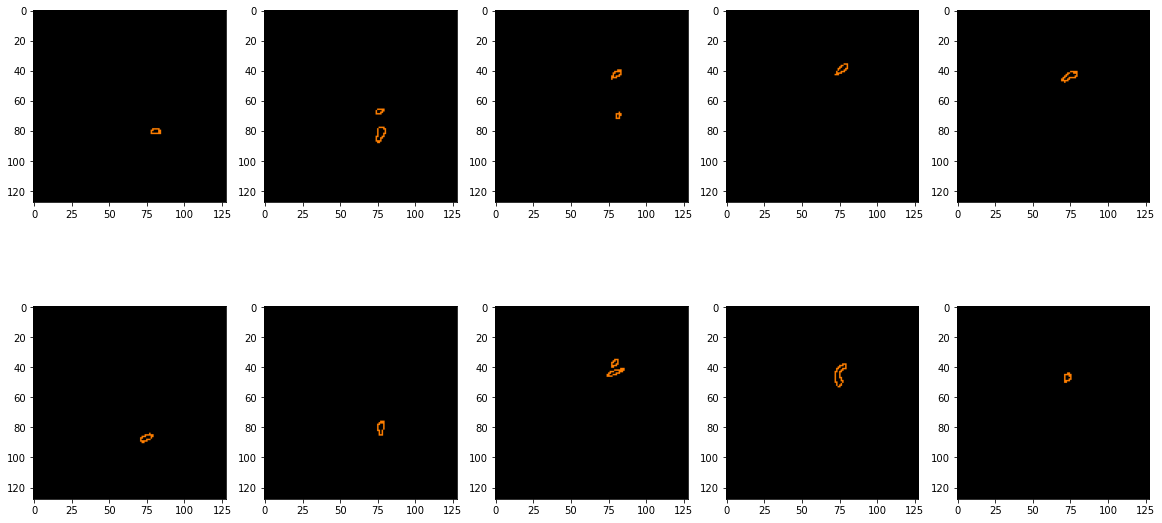

In [4]:
#draw lines with pillow
import math
from PIL import Image, ImageDraw
import json
jsonFiles = glob.glob("001/*.json")
images = []
for i in jsonFiles:    
    file = open(i)
    data = json.load(file)
    im = Image.new("RGB", data['size'])
    draw = ImageDraw.Draw(im)
    shapes = data['shapes']
    for shape in shapes:
        segments = shape['segments']
        strokeColor = shape['strokeColor']
        for segment in segments:
            startEndCoord = [(segment['a'][0], segment['a'][1]),(segment['b'][0], segment['b'][1])]
            draw.line(startEndCoord, fill=strokeColor)
    images.append(im)

#show images with pyplot
quantity = len(images)
colSize = 5
rowSize = int(quantity/colSize)
fig,ax = plt.subplots(rowSize,colSize,figsize=(20,10))
for i in range(len(images)):
    ax[i%2][i//2].imshow(images[i])

In [26]:
dicomdir = dcmread("002/dicomdir")
print(dicomdir.DirectoryRecordSequence)

[(0004, 1400) Offset of the Next Directory Record UL: 0
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 496
(0004, 1430) Directory Record Type               CS: 'PATIENT'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0010, 0010) Patient's Name                      PN: 'Demo'
(0010, 0020) Patient ID                          LO: 'ID20220602091257'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'(0004, 1400) Offset of the Next Directory Record UL: 0
(0004, 1410) Record In-use Flag                  US: 65535
(0004, 1420) Offset of Referenced Lower-Level Di UL: 722
(0004, 1430) Directory Record Type               CS: 'STUDY'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0020) Study Date                          DA: '20220208'
(0008, 0030) Study Time                          TM: '154719'
(0008, 0050) Accession Number  